In [ ]:
import json

js15 = json.load(open('dataset/socrata_metadata_2015-building-energy-benchmarking.json', mode='r'))
js16 = json.load(open('dataset/socrata_metadata_2016-building-energy-benchmarking.json', mode='r'))

In [ ]:
import matplotlib.pyplot as plt
import os
import missingno as msno
import numpy as np
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis


In [ ]:
df15 = pd.read_csv('dataset/2015-building-energy-benchmarking.csv')
df16 = pd.read_csv('dataset/2016-building-energy-benchmarking.csv')

In [ ]:
print(df15.shape)
print(df15.columns)

In [ ]:
print(df16.shape)
print(df16.columns)

In [ ]:
# montrer les differences de colonnes entre les dataset

contained16in15 = [col in df16.columns for col in df15.columns ]
extra15 = df15.columns[np.invert(contained16in15)]
print(extra15)

# describe to what corresponds the extra columns
for col in extra15:
	print(col, ' : ', next(item for item in js15['columns'] if item['name'] == col).get('description'))


In [ ]:
contained15in16 = [col in df15.columns for col in df16.columns ]
extra16 = df16.columns[np.invert(contained15in16)]
print(extra16)

# describe to what corresponds the extra columns
for col in extra16:
	print(col, ' : ', next(item for item in js16['columns'] if item['name'] == col).get('description'))


In [ ]:
# examples of Location
print(df15.loc[0, 'Location'])
print(df16.loc[0, ['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']])
# df15 has location in one single row
# whereas df1516 has one column for each data
# let's split !


In [ ]:
import ast
		
# split Location column
for index, row in df15.iterrows():
	l = ast.literal_eval(df15.loc[index, 'Location'])
	addr = ast.literal_eval(l['human_address'])
	df15.loc[index, 'Latitude'] = l['latitude']
	df15.loc[index, 'Longitude'] = l['longitude']
	df15.loc[index, 'Address'] = addr['address']
	df15.loc[index, 'City'] = addr['city']
	df15.loc[index, 'State'] = addr['state']
	df15.loc[index, 'ZipCode'] = addr['zip']


# convert to correct type as ast convert to str
df15=df15.astype({'Latitude' : 'float64', 'Longitude' : 'float64', 'ZipCode' : 'float64'})


In [ ]:
print(df16['TotalGHGEmissions'].describe())
print(df15['GHGEmissions(MetricTonsCO2e)'].describe())

In [ ]:
print(df16['GHGEmissionsIntensity'].describe())
print(df15['GHGEmissionsIntensity(kgCO2e/ft2)'].describe())

In [ ]:

# columns from df15 and df16 are on the same scale, so they can be merged as is in the resulting dataset
# copy identical columns then will drop all
df15['TotalGHGEmissions'] = df15['GHGEmissions(MetricTonsCO2e)']
df15['GHGEmissionsIntensity'] = df15['GHGEmissionsIntensity(kgCO2e/ft2)']

df15.drop(extra15, axis=1, inplace=True)
df16.drop('Comments', axis=1, inplace=True)


In [ ]:
# merge common columns
df = pd.merge(df15, df16, how='outer')
print(df15.shape, df16.shape, df.shape)



In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.dtypes.value_counts().plot.pie()

In [17]:
# For fun, display the points on a map
import folium
from folium.plugins import MarkerCluster

m = folium.Map(location=[df.loc[0, 'Latitude'], df.loc[0, 'Longitude']], zoom_start=13)
marker_cluster = MarkerCluster().add_to(m)

for index, row in df.iterrows():
	folium.Marker([row['Latitude'], row['Longitude']]).add_to(marker_cluster)

m

In [18]:
df.State.unique()

array(['WA'], dtype=object)

<AxesSubplot:>

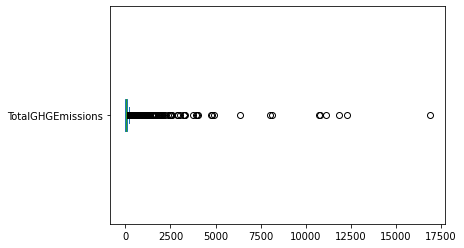

In [19]:
df.TotalGHGEmissions.plot(kind='box', vert= False)

In [20]:
def dropOutlierIQR(df, col):
    Q1 = df[col].quantile(0.25)
    # print(Q1)
    Q3 = df[col].quantile(0.75)
    # print(Q3)
    IQR = Q3 - Q1
    # print(IQR)
    df[col] = df[col][df[col].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR))]

In [21]:
dropOutlierIQR(df, 'TotalGHGEmissions')

<AxesSubplot:>

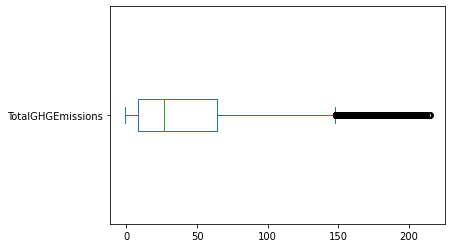

In [22]:
df.TotalGHGEmissions.plot(kind='box', vert= False)

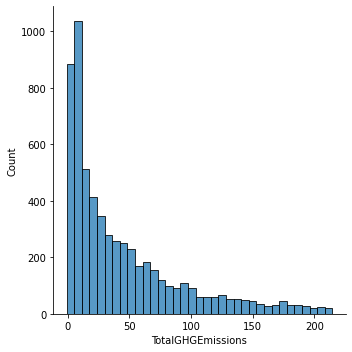

In [23]:
sns.displot(df.TotalGHGEmissions)

<AxesSubplot:>

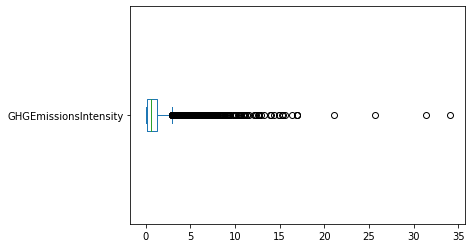

In [24]:
df.GHGEmissionsIntensity.plot(kind='box', vert= False)

In [25]:
dropOutlierIQR(df, 'GHGEmissionsIntensity')

<AxesSubplot:>

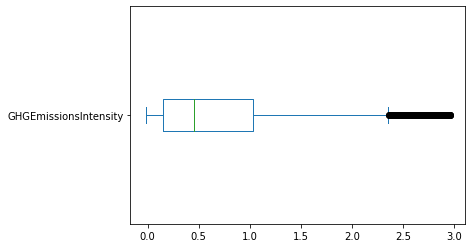

In [26]:
df.GHGEmissionsIntensity.plot(kind='box', vert= False)

<AxesSubplot:xlabel='GHGEmissionsIntensity', ylabel='Density'>

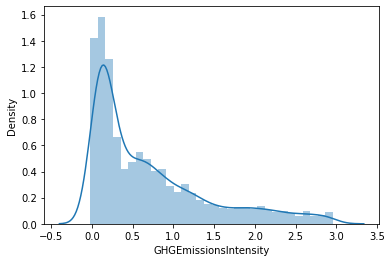

In [27]:
sns.distplot(df.GHGEmissionsIntensity)

<AxesSubplot:ylabel='Frequency'>

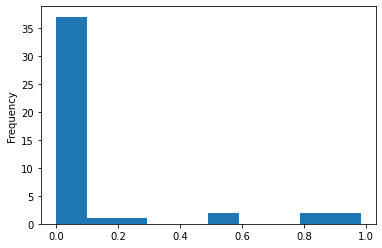

In [28]:
# show columns with (too much) empty values
df.isna().mean().sort_values().plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

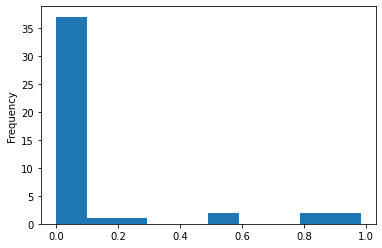

In [29]:
for col in df.columns:
	if df[col].isna().mean() > 0.5:
		print('removing empty column: ', col)
		df.drop(col, axis=1, inplace=True)


<AxesSubplot:>

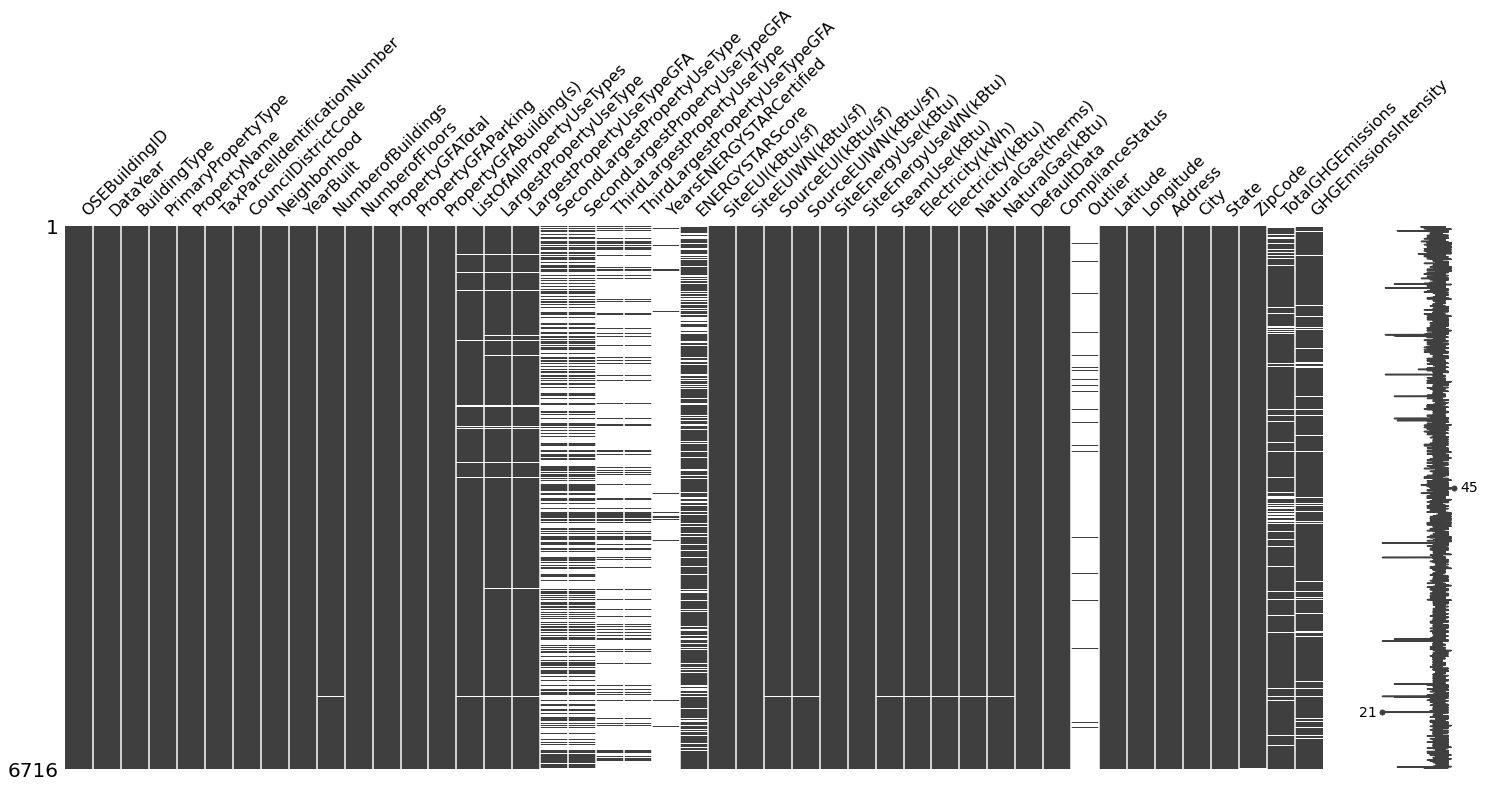

In [30]:
import missingno as msno
msno.matrix(df)

In [31]:
# features correlations
def show_feat_correlations(df):
	correlations = np.abs(df.select_dtypes('float').corr(method="pearson"))

	mask = np.zeros_like(correlations)
	mask[np.triu_indices_from(mask)] = True
	sns.axes_style("white")
	plt.subplots(figsize=(20,20))
	sns.heatmap(correlations, mask=mask, vmax=1, square=True, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True, cmap='cividis')

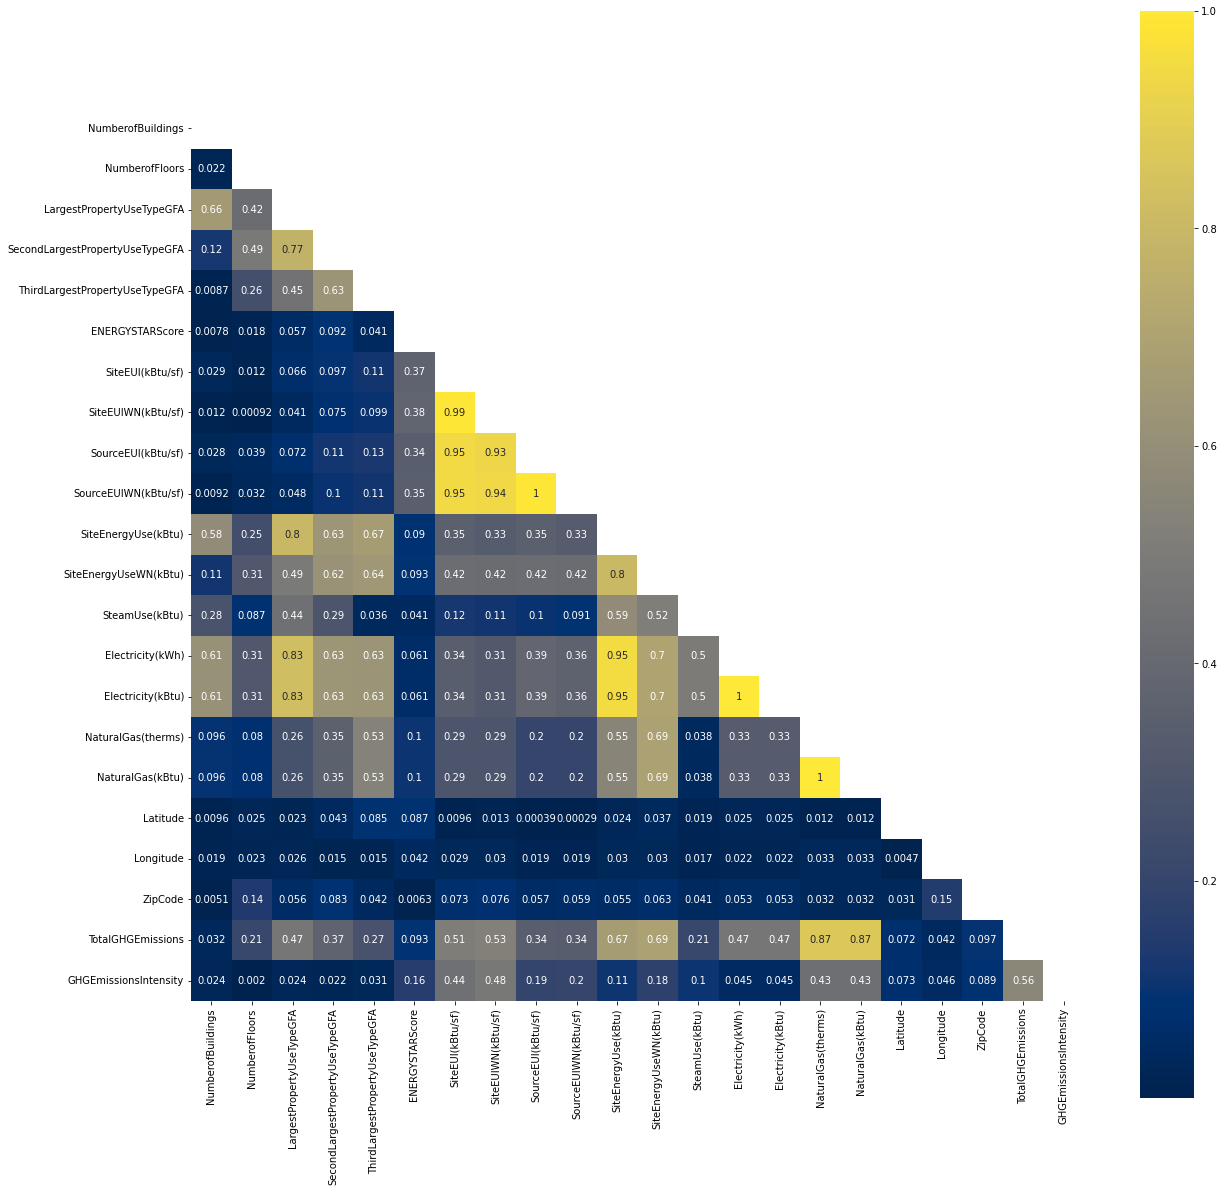

In [32]:
show_feat_correlations(df)

In [33]:
# don't need this feature, since duplicates the one with kBtu
df.drop('Electricity(kWh)', axis=1, inplace=True)

# also, we don't need the features 'WN', they are highly correlated with their siblings 'without WN'
colsWN = []
for col in df.columns:
	if 'WN' in col:
		colsWN.append(col)
df.drop(colsWN, axis=1, inplace=True)

# lastly, we can remove NaturalGas(therms), since it the same than naturalGas(kBtu), only the unit change
df.drop('NaturalGas(therms)', axis=1, inplace=True)

In [34]:
for col in df.columns:
	if df[col].isna().mean() > 0.5:
		df.drop(col, axis=1, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 6715
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  6716 non-null   int64  
 1   DataYear                       6716 non-null   int64  
 2   BuildingType                   6716 non-null   object 
 3   PrimaryPropertyType            6716 non-null   object 
 4   PropertyName                   6716 non-null   object 
 5   TaxParcelIdentificationNumber  6714 non-null   object 
 6   CouncilDistrictCode            6716 non-null   int64  
 7   Neighborhood                   6716 non-null   object 
 8   YearBuilt                      6716 non-null   int64  
 9   NumberofBuildings              6708 non-null   float64
 10  NumberofFloors                 6708 non-null   float64
 11  PropertyGFATotal               6716 non-null   int64  
 12  PropertyGFAParking             6716 non-null   i

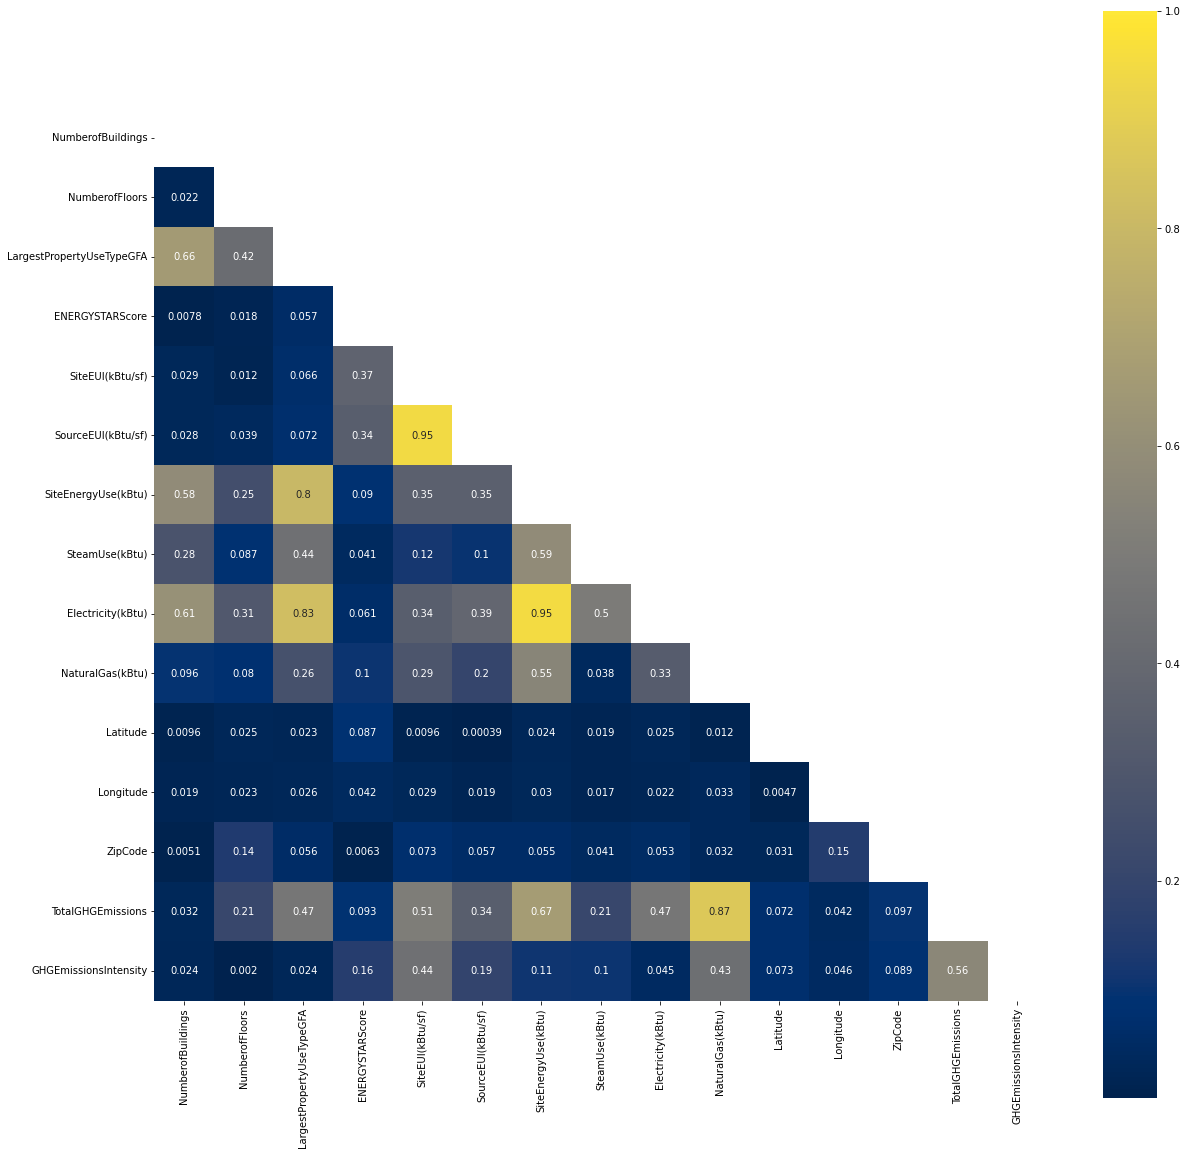

In [36]:
show_feat_correlations(df)